# Read Data Sets

In [1]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

C:\Users\MERCER\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



# Read all train datasets

In [2]:
train_data = pd.read_csv("Train/train.csv")
view_log_train = pd.read_csv("Train/view_log.csv")
item_data = pd.read_csv("Train/item_data.csv")

In [3]:
train_data.head(3)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0


In [4]:
view_log_train.head(3)

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855


In [5]:
item_data.head(3)

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822
2,40383,825,17,8,279,1619


In [6]:
train_data.shape,view_log_train.shape,item_data.shape

((237609, 7), (3118622, 5), (132761, 6))

In [7]:
# check null values
train_data.isnull().any().any(),view_log_train.isnull().any().any(),item_data.isnull().any().any()

(False, False, False)

In [8]:
item_data.duplicated(subset ='item_id' ).sum(),train_data.duplicated(subset ='impression_id' ).sum()

(0, 0)

In [9]:
test_data = pd.read_csv("Test/test.csv")
test_data.head(3)

,impression_id,impression_time,user_id,app_code,os_version,is_4G
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1


In [10]:
test_data.shape

(90675, 6)

# Copy  Train _ Test Data

In [11]:
train_original=train_data.copy() 
test_original=test_data.copy()

In [12]:
# Let’s dive deeper and have a look at the dataset. First of all let’s have a look at the features in the train and test dataset.

train_data.columns, train_data.columns


(Index(['impression_id', 'impression_time', 'user_id', 'app_code', 'os_version',
        'is_4G', 'is_click'],
       dtype='object'),
 Index(['impression_id', 'impression_time', 'user_id', 'app_code', 'os_version',
        'is_4G', 'is_click'],
       dtype='object'))

In [13]:
# Let’s look at the data types of each feature.

train_data.dtypes, test_data.dtypes

(impression_id      object
 impression_time    object
 user_id             int64
 app_code            int64
 os_version         object
 is_4G               int64
 is_click            int64
 dtype: object, impression_id      object
 impression_time    object
 user_id             int64
 app_code            int64
 os_version         object
 is_4G               int64
 dtype: object)

In [14]:
# dateTime is object so convert it in datetime
from datetime import datetime 
train_data['impression_time'] = pd.to_datetime(train_data.impression_time,format='%Y-%m-%d %H:%M:%S') 
test_data['impression_time'] = pd.to_datetime(test_data.impression_time,format='%Y-%m-%d %H:%M:%S')
test_original['impression_time'] = pd.to_datetime(test_original.impression_time,format='%Y-%m-%d %H:%M:%S') 
train_original['impression_time'] = pd.to_datetime(train_original.impression_time,format='%Y-%m-%d %H:%M:%S')

In [15]:
# Let’s look at the data types of each feature.

train_data.dtypes, test_data.dtypes

(impression_id              object
 impression_time    datetime64[ns]
 user_id                     int64
 app_code                    int64
 os_version                 object
 is_4G                       int64
 is_click                    int64
 dtype: object, impression_id              object
 impression_time    datetime64[ns]
 user_id                     int64
 app_code                    int64
 os_version                 object
 is_4G                       int64
 dtype: object)

In [16]:
train_data.head(3)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0


In [17]:
# We made some hypothesis for the effect of hour, day, month and year on the passenger count. So, let’s extract the year, month, day and hour from the Datetime to validate our hypothesis.

for i in (train_data, test_data, test_original, train_original):
    i['year']=i.impression_time.dt.year 
    i['month']=i.impression_time.dt.month 
    i['day']=i.impression_time.dt.day
    i['Hour']=i.impression_time.dt.hour
    i['min'] = i.impression_time.dt.minute

We made a hypothesis for the traffic pattern on weekday and weekend as well. So, let’s make a weekend variable to visualize the impact of weekend on traffic.

We will first extract the day of week from Datetime and then based on the values we will assign whether the day is a weekend or not.

Values of 5 and 6 represents that the days are weekend.



In [18]:
train_data['day of week']=train_data['impression_time'].dt.dayofweek 
temp = train_data['impression_time']

# Test


test_data['day of week']=test_data['impression_time'].dt.dayofweek 
temp = test_data['impression_time']

Let’s assign 1 if the day of week is a weekend and 0 if the day of week in not a weekend.

In [19]:
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0 
temp2 = train_data['impression_time'].apply(applyer) 
train_data['weekend']=temp2

temp2 = test_data['impression_time'].apply(applyer) 
test_data['weekend']=temp2


In [20]:
train_data.head(3)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,year,month,day,Hour,min,day of week,weekend
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,2018,11,15,0,0,3,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,2018,11,15,0,1,3,0
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,2018,11,15,0,2,3,0


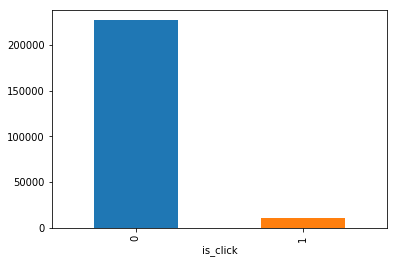

In [21]:
train_data.groupby("is_click")['impression_id'].count().plot.bar()

In [22]:
train_data['is_click'].value_counts()

0    226747
1     10862
Name: is_click, dtype: int64

In [23]:
train_data.head(3)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,year,month,day,Hour,min,day of week,weekend
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,2018,11,15,0,0,3,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,2018,11,15,0,1,3,0
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,2018,11,15,0,2,3,0


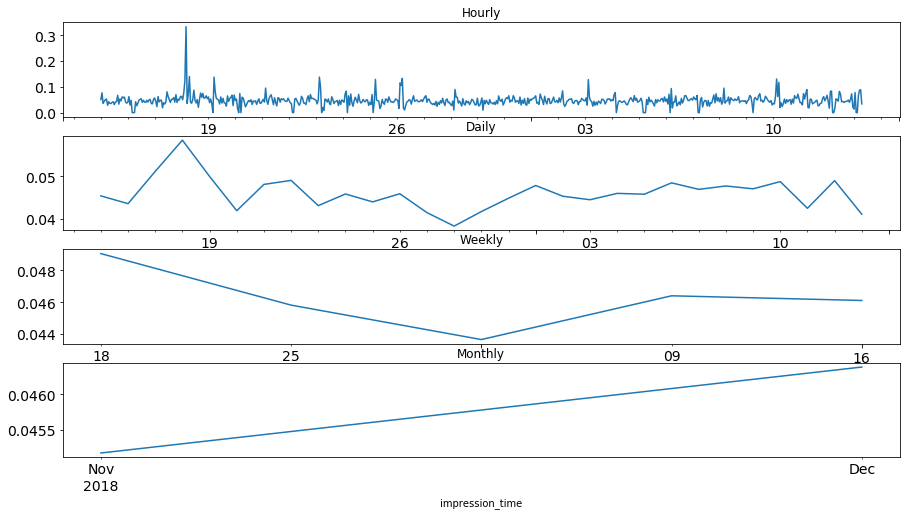

In [24]:
train_data.Timestamp = pd.to_datetime(train_data.impression_time,format='%Y-%m-%d %H:%M') 
train_data.index = train_data.Timestamp 
# Hourly time series 
hourly = train_data.resample('H').mean() 
# Converting to daily mean 
daily = train_data.resample('D').mean() 
# Converting to weekly mean 
weekly = train_data.resample('W').mean() 
# Converting to monthly mean 
monthly = train_data.resample('M').mean()
# Let’s look at the hourly, daily, weekly and monthly time series.

fig, axs = plt.subplots(4,1) 
hourly.is_click.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0]) 
daily.is_click.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1]) 
weekly.is_click.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2]) 
monthly.is_click.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3]) 

plt.show()

In [25]:
test_data.Timestamp = pd.to_datetime(test_data.impression_time,format='%Y-%m-%d %H:%M') 
test_data.index = test_data.Timestamp 
# Hourly time series 
hourly = test_data.resample('H').mean() 
# Converting to daily mean 
daily = test_data.resample('D').mean() 
# Converting to weekly mean 
weekly = test_data.resample('W').mean() 
# Converting to monthly mean 
monthly = test_data.resample('M').mean()


In [26]:
train_data.head(3)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,year,month,day,Hour,min,day of week,weekend
impression_time,,,,,,,,,,,,,,
2018-11-15 00:00:00,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,2018,11,15,0,0,3,0
2018-11-15 00:01:00,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,2018,11,15,0,1,3,0
2018-11-15 00:02:00,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,2018,11,15,0,2,3,0


In [27]:
test_data.head(3)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,year,month,day,Hour,min,day of week,weekend
impression_time,,,,,,,,,,,,,
2018-12-13 07:44:00,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1,2018,12,13,7,44,3,0
2018-12-13 07:45:00,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0,2018,12,13,7,45,3,0
2018-12-13 07:46:00,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1,2018,12,13,7,46,3,0


In [28]:
train_data.shape,test_data.shape

((237609, 14), (90675, 13))

In [29]:
Train=train_data.ix[0:190089]
valid=train_data.ix[190089:237610]

print("Shape Of Train",Train.shape)
print("Shape Of Valid",valid.shape)

Shape Of Train (190089, 14)
Shape Of Valid (47520, 14)


In [30]:
y_train = Train["is_click"] 
Train.drop(['is_click'], axis=1, inplace=True)
Train.drop(['impression_id'], axis=1, inplace=True)
Train.drop(['impression_time'], axis=1, inplace=True)
Train.drop(['user_id'], axis=1, inplace=True)
Train.drop(['os_version'], axis=1, inplace=True)
x_train = Train

y_valid = valid["is_click"] 
valid.drop(['is_click'], axis=1, inplace=True)
valid.drop(['impression_id'], axis=1, inplace=True)
valid.drop(['impression_time'], axis=1, inplace=True)
valid.drop(['user_id'], axis=1, inplace=True)
valid.drop(['os_version'], axis=1, inplace=True)
x_valid = valid



In [31]:
print('Shape of train & target',x_train.shape,y_train.shape)
print('Shape of valid & target',x_valid.shape,y_valid.shape)
print('Shape of test',test_data.shape)


Shape of train & target (190089, 9) (190089,)
Shape of valid & target (47520, 9) (47520,)
Shape of test (90675, 13)


In [32]:
x_train["id"] = np.arange(0,190089)
x_valid['id'] = np.arange(0,47520)

In [33]:
x_valid.head(3)

,app_code,is_4G,year,month,day,Hour,min,day of week,weekend,id
impression_time,,,,,,,,,,
2018-12-04 18:48:00,127,1,2018,12,4,18,48,1,0,0
2018-12-04 18:49:00,127,1,2018,12,4,18,49,1,0,1
2018-12-04 18:50:00,37,1,2018,12,4,18,50,1,0,2


In [34]:
x_train.shape

(190089, 10)

In [35]:
from tsfresh.feature_extraction import extract_features
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters, MinimalFCParameters, EfficientFCParameters
from tsfresh.feature_extraction.settings import from_columns


settings_minimal = MinimalFCParameters() # only a few basic features
settings_minimal

{'sum_values': None,
 'median': None,
 'mean': None,
 'length': None,
 'standard_deviation': None,
 'variance': None,
 'maximum': None,
 'minimum': None}

In [36]:
X_train_tsfresh = extract_features(x_train, column_id='id', default_fc_parameters = settings_minimal)

X_train_tsfresh.head()

Feature Extraction: 100%|██████████| 30/30 [03:02<00:00,  5.09s/it]


variable,Hour__length,Hour__maximum,Hour__mean,Hour__median,Hour__minimum,Hour__standard_deviation,Hour__sum_values,Hour__variance,app_code__length,app_code__maximum,...,weekend__sum_values,weekend__variance,year__length,year__maximum,year__mean,year__median,year__minimum,year__standard_deviation,year__sum_values,year__variance
id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,422.0,...,0.0,0.0,1.0,2018.0,2018.0,2018.0,2018.0,0.0,2018.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,467.0,...,0.0,0.0,1.0,2018.0,2018.0,2018.0,2018.0,0.0,2018.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,259.0,...,0.0,0.0,1.0,2018.0,2018.0,2018.0,2018.0,0.0,2018.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,244.0,...,0.0,0.0,1.0,2018.0,2018.0,2018.0,2018.0,0.0,2018.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,473.0,...,0.0,0.0,1.0,2018.0,2018.0,2018.0,2018.0,0.0,2018.0,0.0


In [37]:
X_valid_tsfresh = extract_features(x_valid, column_id='id', default_fc_parameters = settings_minimal)

X_valid_tsfresh.head()

Feature Extraction: 100%|██████████| 30/30 [00:33<00:00,  1.04s/it]


variable,Hour__length,Hour__maximum,Hour__mean,Hour__median,Hour__minimum,Hour__standard_deviation,Hour__sum_values,Hour__variance,app_code__length,app_code__maximum,...,weekend__sum_values,weekend__variance,year__length,year__maximum,year__mean,year__median,year__minimum,year__standard_deviation,year__sum_values,year__variance
id,,,,,,,,,,,,,,,,,,,,,
0,1.0,18.0,18.0,18.0,18.0,0.0,18.0,0.0,1.0,127.0,...,0.0,0.0,1.0,2018.0,2018.0,2018.0,2018.0,0.0,2018.0,0.0
1,1.0,18.0,18.0,18.0,18.0,0.0,18.0,0.0,1.0,127.0,...,0.0,0.0,1.0,2018.0,2018.0,2018.0,2018.0,0.0,2018.0,0.0
2,1.0,18.0,18.0,18.0,18.0,0.0,18.0,0.0,1.0,37.0,...,0.0,0.0,1.0,2018.0,2018.0,2018.0,2018.0,0.0,2018.0,0.0
3,1.0,18.0,18.0,18.0,18.0,0.0,18.0,0.0,1.0,3.0,...,0.0,0.0,1.0,2018.0,2018.0,2018.0,2018.0,0.0,2018.0,0.0
4,1.0,18.0,18.0,18.0,18.0,0.0,18.0,0.0,1.0,207.0,...,0.0,0.0,1.0,2018.0,2018.0,2018.0,2018.0,0.0,2018.0,0.0


In [38]:
X_train_tsfresh.shape,X_valid_tsfresh.shape

((190089, 72), (47520, 72))

In [39]:
y_train.value_counts()

0    181477
1      8612
Name: is_click, dtype: int64

In [41]:
X_train_tsfresh.to_csv("X_train_final.csv")
X_valid_tsfresh.to_csv("X_valid_tsfresh.csv")

# RF

In [ ]:
'learning_rate':  [0.0001,0.005,0.05,0.01,0.1,1],
          'min_child_weight': [ 1, 3, 5, 7 ,10],
          "colsample_bytree": [ 0.3, 0.4, 0.5 , 0.7 ,0.9],
          'subsample':[0.3, 0.4, 0.5 , 0.7 ,0.9],
          "gamma"  : [ 0.01,0.0, 0.1, 0.2 ],
         

In [40]:
import xgboost as xgb


from sklearn.model_selection import RandomizedSearchCV
param1 = {'n_estimators':  [50,100,200,300,500,1000] ,
         'max_depth' :  [10,15,20,25,50,100],
         'reg_lambda':  [0.05,0.01,0.1,5,10,50,100] ,
         'reg_alpha' :  [0.05,5,10,50,100],
          'scale_pos_weight' : [0.2,0.1,20]
         }


estimator1 = xgb.XGBClassifier(objective = 'binary:logistic' ,eval_metric= 'auc',booster = 'gbtree')
Rsearch1= RandomizedSearchCV(estimator1,param_distributions = param1,scoring='roc_auc',n_jobs=10,  cv=3,verbose=21)
Rsearch1.fit(X_train_tsfresh,y_train)
Rsearch1.best_params_, Rsearch1.best_score_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:  7.6min
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:  9.0min
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:  9.0min
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:  9.9min
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed: 10.9min
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed: 11.8min
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed: 23.4min
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed: 34.9min
[Parallel(n_jobs=10)]: Done  13 out of  30 | elapsed: 49.4min remaining: 64.6min
[Parallel(n_jobs=10)]: Done  15 out of  30 | elapsed: 53.7min remaining: 53.7min
[Parallel(n_jobs=10)]: Done  17 out of  30 | elapsed: 54.2min remaining: 41.5mi

({'scale_pos_weight': 0.2,
  'reg_lambda': 5,
  'reg_alpha': 5,
  'n_estimators': 100,
  'max_depth': 20},
 0.6788380024936125)

In [40]:
import xgboost as xgb


from sklearn.model_selection import GridSearchCV
param1 = {'n_estimators':  [100,150,200,300,500,1000],
         'max_depth' :  [20,25,50,80,100]
         
         }


estimator1 = xgb.XGBClassifier(objective = 'binary:logistic' ,eval_metric= 'auc',booster = 'gbtree',scale_pos_weight = 0.2,reg_lambda=5,reg_alpha=5)
Rsearch1= GridSearchCV(estimator1,param_grid = param1,scoring='roc_auc',n_jobs=10,  cv=10,verbose=21)
Rsearch1.fit(X_train_tsfresh,y_train)
Rsearch1.best_params_, Rsearch1.best_score_

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:  4.7min
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:  4.7min
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:  4.7min
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:  4.7min
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:  4.8min
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:  4.8min
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:  4.8min
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:  4.8min
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed:  4.8min
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed:  4.9min
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed: 12.7min
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed: 12.8min
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed: 12.8min
[Parallel(n_jobs=10)]: Done  14 tasks      | elapsed: 12.9min
[Parallel(n_jobs=10)]: Done  15 tasks      | elapsed: 1

[Parallel(n_jobs=10)]: Done 132 tasks      | elapsed: 176.0min
[Parallel(n_jobs=10)]: Done 133 tasks      | elapsed: 176.2min
[Parallel(n_jobs=10)]: Done 134 tasks      | elapsed: 176.3min
[Parallel(n_jobs=10)]: Done 135 tasks      | elapsed: 176.4min
[Parallel(n_jobs=10)]: Done 136 tasks      | elapsed: 176.5min
[Parallel(n_jobs=10)]: Done 137 tasks      | elapsed: 177.5min
[Parallel(n_jobs=10)]: Done 138 tasks      | elapsed: 177.8min
[Parallel(n_jobs=10)]: Done 139 tasks      | elapsed: 178.5min
[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed: 179.1min
[Parallel(n_jobs=10)]: Done 141 tasks      | elapsed: 186.8min
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed: 187.5min
[Parallel(n_jobs=10)]: Done 143 tasks      | elapsed: 187.5min
[Parallel(n_jobs=10)]: Done 144 tasks      | elapsed: 187.6min
[Parallel(n_jobs=10)]: Done 145 tasks      | elapsed: 187.7min
[Parallel(n_jobs=10)]: Done 146 tasks      | elapsed: 187.9min
[Parallel(n_jobs=10)]: Done 147 tasks      | elapsed: 1

[Parallel(n_jobs=10)]: Done 263 tasks      | elapsed: 521.5min
[Parallel(n_jobs=10)]: Done 264 tasks      | elapsed: 521.6min
[Parallel(n_jobs=10)]: Done 265 tasks      | elapsed: 521.6min
[Parallel(n_jobs=10)]: Done 266 tasks      | elapsed: 522.3min
[Parallel(n_jobs=10)]: Done 267 tasks      | elapsed: 523.4min
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed: 524.4min
[Parallel(n_jobs=10)]: Done 269 tasks      | elapsed: 524.5min
[Parallel(n_jobs=10)]: Done 270 tasks      | elapsed: 525.5min
[Parallel(n_jobs=10)]: Done 271 tasks      | elapsed: 535.6min
[Parallel(n_jobs=10)]: Done 272 tasks      | elapsed: 535.8min
[Parallel(n_jobs=10)]: Done 273 tasks      | elapsed: 536.2min
[Parallel(n_jobs=10)]: Done 274 tasks      | elapsed: 536.4min
[Parallel(n_jobs=10)]: Done 275 tasks      | elapsed: 537.2min
[Parallel(n_jobs=10)]: Done 276 tasks      | elapsed: 537.5min
[Parallel(n_jobs=10)]: Done 277 tasks      | elapsed: 537.5min
[Parallel(n_jobs=10)]: Done 278 tasks      | elapsed: 5

({'max_depth': 25, 'n_estimators': 100}, 0.6814122806532834)

In [ ]:
n1=Rsearch1.best_params_['n_estimators']
d1 = Rsearch1.best_params_['max_depth']
print(Rsearch1.best_score_)
print(n1)
print(d1)

In [ ]:
import xgboost as xgb


from sklearn.model_selection import GridSearchCV
param2 = {'reg_lambda':  [0,10,50,80,100,300,500]
         
         
         }


estimator2 = xgb.XGBClassifier(objective = 'binary:logistic' ,max_depth=25,n_estimators=500,eval_metric= 'auc',scale_pos_weight = 0.2)
Rsearch2= GridSearchCV(estimator2,param_grid = param2,scoring='roc_auc',n_jobs=10,  cv=10,verbose=21)
Rsearch2.fit(X_train_tsfresh,y_train)
Rsearch2.best_params_, Rsearch2.best_score_

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed: 47.3min
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed: 47.8min
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed: 47.8min
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed: 47.9min
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed: 47.9min
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed: 47.9min
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed: 48.0min
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed: 48.0min
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed: 48.0min
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed: 48.1min
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed: 102.3min
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed: 102.5min
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed: 102.6min
[Parallel(n_jobs=10)]: Done  14 tasks      | elapsed: 102.6min
[Parallel(n_jobs=10)]: Done  15 tasks      | elapse

In [ ]:
,reg_lambda =100,reg_alpha = 5

In [53]:
import xgboost as xgb
estimator_main =xgb.XGBClassifier(objective = 'binary:logistic',
eval_metric= 'auc',max_depth=25,n_estimators=500,scale_pos_weight =0.2,reg_lambda =100)

estimator_main.fit(X_train_tsfresh,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eval_metric='auc', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=25,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=100, scale_pos_weight=0.2, seed=None,
       silent=None, subsample=1, verbosity=1)

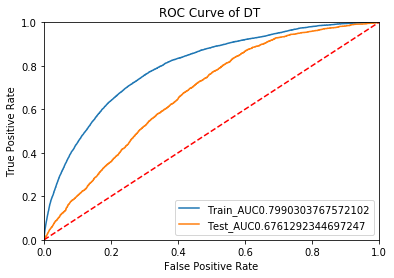

In [54]:
from  sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt


score_roc_train = estimator_main.predict_proba(X_train_tsfresh)
fpr_train, tpr_train, threshold_train = roc_curve(y_train, score_roc_train[:,1])
roc_auc_train = auc(fpr_train, tpr_train)


score_roc_valid = estimator_main.predict_proba(X_valid_tsfresh)
fpr_valid, tpr_valid, threshold_valid = roc_curve(y_valid, score_roc_valid[:,1])
roc_auc_valid = auc(fpr_valid , tpr_valid)





plt.plot(fpr_train, tpr_train, label = "Train_AUC"+str(auc(fpr_train, tpr_train)))
plt.plot(fpr_valid, tpr_valid, label = "Test_AUC"+str(auc(fpr_valid, tpr_valid)))
plt.legend(loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of DT ')
plt.show()


In [46]:
y_train_pred =  estimator_main.predict_proba(X_train_tsfresh)
-

In [44]:

test_data.drop(['impression_id'], axis=1, inplace=True)
test_data.drop(['impression_time'], axis=1, inplace=True)
test_data.drop(['user_id'], axis=1, inplace=True)
test_data.drop(['os_version'], axis=1, inplace=True)



In [45]:
test_data.head(3)

,app_code,is_4G,year,month,day,Hour,min,day of week,weekend
impression_time,,,,,,,,,
2018-12-13 07:44:00,127,1,2018,12,13,7,44,3,0
2018-12-13 07:45:00,44,0,2018,12,13,7,45,3,0
2018-12-13 07:46:00,296,1,2018,12,13,7,46,3,0


In [46]:
test_data['id'] = np.arange(0,90675)
test_data.head(3)

,app_code,is_4G,year,month,day,Hour,min,day of week,weekend,id
impression_time,,,,,,,,,,
2018-12-13 07:44:00,127,1,2018,12,13,7,44,3,0,0
2018-12-13 07:45:00,44,0,2018,12,13,7,45,3,0,1
2018-12-13 07:46:00,296,1,2018,12,13,7,46,3,0,2


In [47]:
X_test_tsfresh = extract_features(test_data, column_id='id', default_fc_parameters = settings_minimal)

X_test_tsfresh.head()

Feature Extraction: 100%|██████████| 30/30 [01:38<00:00,  2.30s/it]


variable,Hour__length,Hour__maximum,Hour__mean,Hour__median,Hour__minimum,Hour__standard_deviation,Hour__sum_values,Hour__variance,app_code__length,app_code__maximum,...,weekend__sum_values,weekend__variance,year__length,year__maximum,year__mean,year__median,year__minimum,year__standard_deviation,year__sum_values,year__variance
id,,,,,,,,,,,,,,,,,,,,,
0,1.0,7.0,7.0,7.0,7.0,0.0,7.0,0.0,1.0,127.0,...,0.0,0.0,1.0,2018.0,2018.0,2018.0,2018.0,0.0,2018.0,0.0
1,1.0,7.0,7.0,7.0,7.0,0.0,7.0,0.0,1.0,44.0,...,0.0,0.0,1.0,2018.0,2018.0,2018.0,2018.0,0.0,2018.0,0.0
2,1.0,7.0,7.0,7.0,7.0,0.0,7.0,0.0,1.0,296.0,...,0.0,0.0,1.0,2018.0,2018.0,2018.0,2018.0,0.0,2018.0,0.0
3,1.0,7.0,7.0,7.0,7.0,0.0,7.0,0.0,1.0,207.0,...,0.0,0.0,1.0,2018.0,2018.0,2018.0,2018.0,0.0,2018.0,0.0
4,1.0,7.0,7.0,7.0,7.0,0.0,7.0,0.0,1.0,242.0,...,0.0,0.0,1.0,2018.0,2018.0,2018.0,2018.0,0.0,2018.0,0.0


In [48]:
X_test_tsfresh.shape

(90675, 72)

In [49]:
y_test_pred = estimator_main.predict_proba(X_test_tsfresh)

In [50]:
len(y_test_pred)

90675

In [51]:
test_original.shape

(90675, 11)

In [52]:


# Get IDs and predictions
predids=test_original['impression_id']
y_id=predids.values.tolist()
preddf=pd.DataFrame({'impression_id':y_id,
                     'is_click':y_test_pred[:,1]})

#look at predictions
preddf.head(3)




,impression_id,is_click
0,a9e7126a585a69a32bc7414e9d0c0ada,0.013393
1,caac14a5bf2ba283db7708bb34855760,0.003185
2,13f10ba306a19ce7bec2f3cae507b698,0.015397


In [53]:
# SAVE DF
preddf.to_csv('submission_xgb_3_ts.csv',index=False)

